In [33]:
import sys
import os

import numpy as nplk
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sys.path.insert(0, '../../')
import ccal
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

In [16]:
nfeatures = 10
nelement = 10
features = ccal.support.make_random_features(nfeatures, nelement)
ref = ccal.support.make_random_features(1, nelement)

In [17]:
import os
import math

import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.spatial import distance
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, cophenet
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns

from ccal.visualize import CMAP_CONTINUOUS, plot_nmf_result, plot_features_and_reference, FONT16_BOLD, FONT12_BOLD, FONT20_BOLD, BLACK
from ccal.information import information_coefficient, cmi_diff, cmi_ratio
from ccal.support import verbose_print, establish_path

In [99]:
def rank_features_against_reference(features, ref,
                                    features_type='continuous', ref_type='continuous',
                                    features_ascending=False, ref_ascending=False, ref_sort=True,
                                    metric='ic', nsampling=3, confidence=0.95, nperm=3,
                                    title=None, annotation_columns=('IC', 'Global', 'P-Value', 'CI', 'FDR (BH)'),
                                    n_features=0.95, rowname_size=25,
                                    output_prefix=None, figure_type='.png'):
    """
    Compute features vs. `ref`.
    :param features: pandas DataFrame (n_features, m_elements), must have indices and columns
    :param ref: pandas Series (m_elements), must have name and columns, which must match 'features`'s
    :param metric: str, {information_coef}
    :param features_type: str, {continuous, categorical, binary}
    :param ref_type: str, {continuous, categorical, binary}
    :param features_ascending: bool, True if features score increase from top to bottom, False otherwise
    :param ref_ascending: bool, True if ref values increase from left to right, False otherwise
    :param ref_sort: bool, sort each ref or not
    :param title: string for the title of heatmap
    :param annotation_columns: list, annotation column names to include in the plot
    :param n_features: int or float, number threshold if >= 1 and quantile threshold if < 1
    :param rowname_size: int, the maximum length of a feature name label
    :param output_prefix: str, file path prefix to save the result (.txt) and figure (`figure_type`)
    :param figure_type: str, file type to save the output figure
    :return: None
    """
    verbose_print('Computing features vs. {} using {} metric ...'.format(ref.name, metric))

    # Establish output file path
    if output_prefix:
        output_prefix = os.path.abspath(output_prefix)
        establish_path(output_prefix)

    # Use only the intersecting columns
    # TODO: preserve order
    col_intersection = set(features.columns) & set(ref.index)
    verbose_print(
        'Using {} intersecting columns from features and ref, which have {} and {} columns respectively ...'.format(
            len(col_intersection), features.shape[1], ref.size))
    features = features.ix[:, col_intersection]
    ref = ref.ix[col_intersection]

    # Sort ref and use its sorted indices to sort features indices
    if ref_sort:
        ref = ref.sort_values(ascending=ref_ascending)
        features = features.reindex_axis(ref.index, axis=1)

    # Compute scores, join them in features, and rank features based on scores
    scores = compute_against_reference(features, ref, metric=metric, nsampling=nsampling, confidence=confidence, nperm=nperm)
    # TODO: sort by features_ascending
    features = features.reindex(scores.index)

    # Make annotation
    annotations = pd.DataFrame()
    annotations['IC'] = ['{0:.2f}'.format(x) for x in scores.ix[:, 'ic']]
    annotations['P'] = ['{0:.2f}'.format(x) for x in scores.ix[:, 'Global P-Value']]
    annotations['CI'] = scores.ix[:, '{} CI'.format(confidence)].tolist()
    
    #     if output_prefix:
    #         filename = output_prefix + '.txt'
    #         features.to_csv(filename, sep='\t')
    #         verbose_print('Saved the result as {}.'.format(filename))

    
    # Plot features panel
    verbose_print('Plotting top {} features vs. ref ...'.format(n_features))
    if n_features < 1:
        indices_to_plot = features.iloc[:, -1] >= features.iloc[:, -1].quantile(n_features)
        indices_to_plot |= features.iloc[:, -1] <= features.iloc[:, -1].quantile(1 - n_features)
    else:
        indices_to_plot = features.index[:n_features].tolist() + features.index[-n_features:].tolist()
    plot_features_and_reference(features, ref, annotations,
                                features_type=features_type, ref_type=ref_type,
                                title=title, rowname_size=rowname_size,
                                filename_prefix=output_prefix, figure_type=figure_type)


def compute_against_reference(features, ref, metric='ic', nsampling=3, confidence=0.95, nperm=3):
    """
    Compute scores[i] = `features`[i] vs. `ref` with computation using `metric`.
    :param features: pandas DataFrame (n_features, m_elements), must have indices and columns
    :param ref: pandas Series (m_elements), must have indices, which must match 'features`'s columns
    :param metric: str, {information}
    :return: pandas DataFrame (n_features, 1),
    """
    # Compute score[i] = <features>[i] vs. <ref>
    if metric is 'ic':
        function = information_coefficient
    elif metric is 'information_cmi_diff':
        function = cmi_diff
    elif metric is 'information_cmi_ratio':
        function = cmi_ratio
    else:
        raise ValueError('Unknown metric {}.'.format(metric))

    # Score
    scores = pd.DataFrame([function(row[1], ref) for row in features.iterrows()],
                          index=features.index, columns=[metric])

    print('Bootstrapping to get {} confidence interval ...'.format(confidence))
    confidence_intervals = pd.DataFrame(index=features.index,
                                        columns=['{} CI'.format(confidence)])
    # Random sample elements
    nsample = math.ceil(0.632 * features.shape[0])
    sampled_scores = np.empty((features.shape[0], nsampling))
    for i in range(nsampling):
        sample_indices = np.random.choice(features.columns.tolist(), int(nsample)).tolist()
        sampled_features = features.ix[:, sample_indices]
        sampled_ref = ref.ix[sample_indices]
        # Compute sample score
        for j, (idx, s) in enumerate(sampled_features.iterrows()):
            sampled_scores[j, i] = function(s, sampled_ref)
    # Get confidence interval
    z_critical = stats.norm.ppf(q=confidence)
    for i, f in enumerate(sampled_scores):
        mean = f.mean()
        stdev = f.std()
        moe = z_critical * (stdev / math.sqrt(f.size))
        confidence_intervals.iloc[i] = '<{0:.2f}, {0:.2f}>'.format(mean - moe, mean + moe)

    print('Performing permutation test with {} permutations ...'.format(nperm))
    permutation_pvals_and_fdrs = pd.DataFrame(index=features.index,
                                              columns=['Local P-Value', 'Global P-Value', 'FDR (BH)'])
    permutation_scores = np.empty((features.shape[0], nperm))
    # Permute ref and compute score against it
    shuffled_ref = np.array(ref)
    for i in range(nperm):
        np.random.shuffle(shuffled_ref)
        for j, (idx, s) in enumerate(features.iterrows()):
            permutation_scores[j, i] = information_coefficient(s, shuffled_ref)
    # Compute permutation p-value
    all_permutation_scores = permutation_scores.flatten()
    for i, (idx, f) in enumerate(scores.iterrows()):
        # Local P-Value
        local_pval = float(sum(permutation_scores[i, :] > float(f)) / nperm)
        if not local_pval:
            local_pval = float(1 / nperm)
        permutation_pvals_and_fdrs.ix[idx, 'Local P-Value'] = local_pval

        # Global P-Value
        global_pval = float(sum(all_permutation_scores > float(f)) / (nperm * features.shape[0]))
        if not global_pval:
            global_pval = float(1 / (nperm * features.shape[0]))
        permutation_pvals_and_fdrs.ix[idx, 'Global P-Value'] = global_pval
    # Compute permutation FDR
    permutation_pvals_and_fdrs.ix[:, 'FDR (BH)'] = multipletests(permutation_pvals_and_fdrs.ix[:, 'Global P-Value'],
                                                                 method='fdr_bh')[1]
    return pd.concat([scores, confidence_intervals, permutation_pvals_and_fdrs], axis=1).sort_values('ic')


def plot_features_and_reference(features, ref, annotations, features_type='continuous', ref_type='continuous',
                                title=None, rowname_size=25, filename_prefix=None, figure_type='.png'):
    """
    Plot a heatmap panel.
    :param features: pandas DataFrame (n_features, m_elements), must have indices and columns
    :param ref: pandas Series (m_elements), must have indices, which must match 'features`'s columns
    :param annotations:  pandas DataFrame (n_features, n_annotations), must have indices, which must match 'features`'s
    :param features_type: str, {continuous, categorical, binary}
    :param ref_type: str, {continuous, categorical, binary}
    :param title: str, figure title
    :param rowname_size: int, the maximum length of a feature name label
    :param filename_prefix: str, file path prefix to save the figure
    :param figure_type: str, file type to save the figure
    :return: None
    """
    features_nrow, features_ncol = features.shape

    # Set figure size
    if features_ncol < 10:
        fig_width = 10 / 6
    elif features_ncol < 35:
        fig_width = features_ncol / 6
    else:
        fig_width = 35 / 6

    if features_nrow < 3:
        fig_height = 4 / 3
    else:
        fig_height = features_nrow / 3

    fig = plt.figure(figsize=(fig_width, fig_height), dpi=900)
    text_margin = 1

    # Set heatmap parameters for ref
    if ref_type is 'continuous':
        ref_cmap = CMAP_CONTINUOUS
        ref_min, ref_max = -2.5, 2.5
    elif ref_type is 'categorical':
        ref_cmap = CMAP_CATEGORICAL
        ref_min, ref_max = 0, np.unique(ref.values).size
    elif ref_type is 'binary':
        ref_cmap = CMAP_BINARY
        ref_min, ref_max = 0, 1
    else:
        raise ValueError('Unknown ref_type {}.'.format(ref_type))

    # Set heatmap parameters for features
    if features_type is 'continuous':
        features_cmap = CMAP_CONTINUOUS
        features_min, features_max = -2.5, 2.5
    elif features_type is 'categorical':
        features_cmap = CMAP_CATEGORICAL
        features_min, features_max = 0, np.unique(features.values).size
    elif features_type is 'binary':
        features_cmap = CMAP_BINARY
        features_min, features_max = -0.025, 1
    else:
        raise ValueError('Unknown features_type {}.'.format(features_type))

    # Normalize
    if features_type is 'continuous':
        verbose_print('Normalizing continuous features ...')
        for i, (idx, s) in enumerate(features.iterrows()):
            mean = s.mean()
            std = s.std()
            for j, v in enumerate(s):
                features.iloc[i, j] = (v - mean) / std
    if ref_type is 'continuous':
        verbose_print('Normalizing continuous ref ...')
        ref = (ref - ref.mean()) / ref.std()

    # Plot ref
    ref_ax = plt.subplot2grid((features_nrow, 1), (0, 0))
    ref_ax.text(features_ncol / 2, 4 * text_margin, title,
                horizontalalignment='center', verticalalignment='bottom', **FONT16_BOLD)
    sns.heatmap(pd.DataFrame(ref).T, vmin=ref_min, vmax=ref_max, robust=True,
                cmap=ref_cmap, linecolor=BLACK, fmt=None, xticklabels=False, yticklabels=False, cbar=False)
    # Add ref texts
    ref_ax.text(-text_margin, 0.5, ref.name,
                horizontalalignment='right', verticalalignment='center', **FONT12_BOLD)
    for j, a in enumerate(annotations.columns):
        ref_ax.text(features_ncol + text_margin * (4 * j + text_margin), 0.5, a,
                         horizontalalignment='left', verticalalignment='center', **FONT12_BOLD)

    # Add binary or categorical ref labels
    if ref_type in ('binary', 'categorical'):
        # Find boundaries
        boundaries = [0]
        prev_v = ref.iloc[0]
        for i, v in enumerate(ref.iloc[1:]):
            if prev_v != v:
                boundaries.append(i + 1)
            prev_v = v
        boundaries.append(features_ncol)
        # Calculate label's horizontal positions
        label_horizontal_positions = []
        prev_b = 0
        for b in boundaries[1:]:
            label_horizontal_positions.append(b - (b - prev_b) / 2)
            prev_b = b
        # TODO: get_unique_in_order
        unique_ref_labels = np.unique(ref.values)[::-1]
        # Add labels
        for i, pos in enumerate(label_horizontal_positions):
            # TODO: verticalalignment should be default so remove this
            ref_ax.text(pos, 1, unique_ref_labels[i],
                        horizontalalignment='center', verticalalignment='bottom', **FONT12_BOLD)

    # Plot features
    features_ax = plt.subplot2grid((features_nrow, 1), (0, 1), rowspan=features_nrow)
    sns.heatmap(features, vmin=features_min, vmax=features_max, robust=True,
                cmap=features_cmap, linecolor=BLACK, fmt=None, xticklabels=False, yticklabels=False, cbar=False)

    for i, idx in enumerate(features.index):
        y = features_nrow - i - 0.5
        features_ax.text(-text_margin, y, idx[:rowname_size],
                         horizontalalignment='right', verticalalignment='center', **FONT12_BOLD)
        for j, a in enumerate(annotations.iloc[i, :]):
            features_ax.text(features_ncol + text_margin * (4 * j + text_margin), y, a,
                             horizontalalignment='left', verticalalignment='center', **FONT12_BOLD)

    fig.tight_layout()
    plt.show(fig)

    if filename_prefix:
        filename = filename_prefix + figure_type
        fig.savefig(filename)
        verbose_print('Saved the figure as {}.'.format(filename))

<10:02:13.470188> Computing features vs. Feature 0 using ic metric ...
<10:02:13.470259> Using 10 intersecting columns from features and ref, which have 10 and 10 columns respectively ...
Bootstrapping to get 0.95 confidence interval ...
Performing permutation test with 3 permutations ...


../../ccal/information.py:84: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  v = v[overlap] + jitters[i]


<10:02:15.272354> Plotting top 0.95 features vs. ref ...
<10:02:15.274977> Normalizing continuous features ...
<10:02:15.287172> Normalizing continuous ref ...


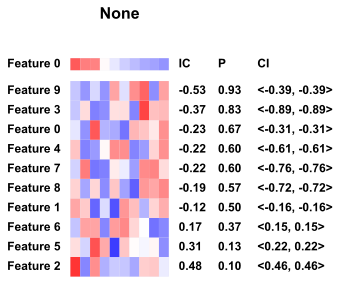

In [100]:
scores = rank_features_against_reference(features, ref)